# SRRF Algorithm Explorations
### Adam 2/26/16

after that nature comms paper that we all know and love

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import RectBivariateSpline

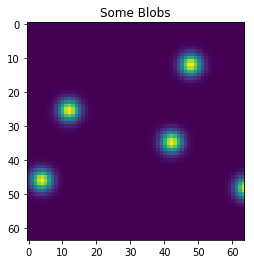

In [275]:
# maybe make your own low-budget convolution function ?  
#take a source matrix and a kernel matrix, and then return the convolution of the two

# define a source image
width = 64
height = 64
pixel_size = 128

# create an empty numpy array of the right dimensions
source = np.zeros( shape = (width,height) )

# a function to put some spots into my empty array
def add_spot(xi, yi, image_array, tau = 20):
    output = image_array.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i,j] += np.exp( -np.sqrt(( (i-xi) / tau )**2+( (j-yi) / tau )**2)**2 )
    return output

# Inefficiently add some number of spots!
n_spots = 5;

for (xs,ys) in zip([np.random.rand()*width for i in range(n_spots)],[np.random.rand()*width for i in range(n_spots)]):          
    source = add_spot(xs,ys,source,3)
            
plt.imshow(source)
plt.title('Some Blobs')
plt.show()

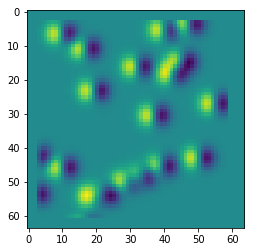

In [245]:
# ok, so turn this into a function that does a legit convolution

# An x-derivative kernel to convolve (convolute?) with
kernel0 = np.zeros(shape=(3,5))
kernel0[:,0:2] = -1 
kernel0[:,3:] = 1

# a y-derivative kernel to ...
kernel1 = np.zeros(shape=(5,3))
kernel1[0:2,:] = -1 
kernel1[3:,:] = 1

# but I want to fix it so that it's centering the kernel over the source point, so I need to offset by floor(length/2)

def conv(src, kernel):
    
    k_offset = [int(np.floor(i/2)) for i in kernel.shape]
    fail_counter = 0
    buffer = np.zeros_like(src)
    
    for i in range(kernel.shape[0],src.shape[0]-kernel.shape[0]):
        for j in range(kernel.shape[0], src.shape[1]-kernel.shape[1]):
            temp_sum = 0
            for p in range(kernel.shape[0]):
                for q in range(kernel.shape[1]):
                    try:
                        temp_sum += src[i+p-k_offset[0],j+q-k_offset[1]]*kernel[p,q]
                    except:
                        fail_counter += 1
                        print('fail')
                        if fail_counter > 600:
                            return 'FAIL'
            buffer[i,j] = temp_sum
    return buffer

plt.imshow(conv(source,kernel0))
plt.show()

Text(0.5,1,'|(Gy,Gx|')

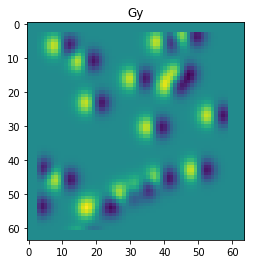

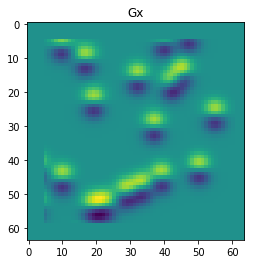

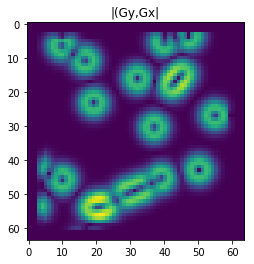

In [247]:
# calculate the magnitude of the gradient vector (Gx,Gy)

Gy = conv(source, kernel0)
Gx = conv(source, kernel1)

plt.figure() 
plt.imshow(Gy)
plt.title('Gy')

plt.figure()
plt.imshow(Gx)
plt.title('Gx')

plt.figure()
plt.imshow( np.sqrt(Gy**2+Gx**2) )
plt.title('|(Gy,Gx|')

In [20]:
# ok - so what are the missing pieces...
# 1. calculate gradients X
# 2. subsample image? X
# 2. find test points on ring around analysis point... ok this is not bad - can interpolate from continuous coords from 
# 3. calculate line to fluorophore (trivial)
# 4. calculate min distance from test point to fluorophore line (see equation in SI)

In [21]:
# so what am i missing?  What's the point of subpixel division?  AFAIK, the source is unchanged up through 
# the gradient calculation, and then is subpixeled...
# so lets's assume that's right - so you make a new image with Nx the pixels per dimension, and then move along
# getting interpolated Gx,Gy values... 
# so what's the next small step... define a function that returns coordinates based on ring radius and N samples

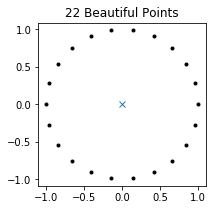

In [254]:
# make a function for ring-sampling around the test point.
# takes a radius and number of samples, and returns a list of points centered in a ring around 0,0
def get_ring_samples(radius, samples):
    output = []
    for i in range(samples):
        theta = i*2*np.pi / samples
        output.append( ( radius*np.cos(theta) , radius*np.sin(theta) ))
    return output

points = get_ring_samples(1,22)

plt.figure(figsize=(3,3))
plt.plot(0,0,'x')
for (x,y) in points:
    plt.plot(x,y,'k.')
plt.title('22 Beautiful Points')
plt.show()


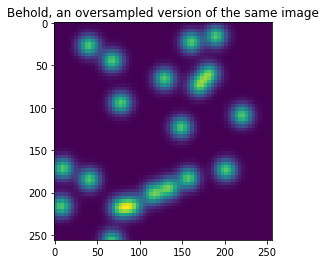

In [256]:
# test out an interpolation function for getting in-between-pixel values of the gradient

s = RectBivariateSpline(range(width),range(height),source)
test_im = np.zeros( shape = [s*4 for s in source.shape])

for i in range(test_im.shape[0]):
    for j in range(test_im.shape[1]):
        test_im[i,j] = s(intfloor(i/4),intfloor(j/4))

plt.imshow(test_im)
plt.title("Behold, an oversampled version of the same image")
plt.show()

In [257]:
# OK here's the big kahuna... maybe I'll break it up a bit more

def calc_radiality(source, ring_samples, scale = 2):
    
    # helper function
    def intfloor(x):
        return int(np.floor(x))
    
    #make the output matrix, Nx as big as the source
    output = np.zeros(shape = [s*scale for s in source.shape] )

    # calculate x and y gradients
    Gy = conv(source, kernel0)
    Gx = conv(source, kernel1)
    
    # create an interpolation function for Gx, Gy
    Sx = RectBivariateSpline(range(Gx.shape[0]),range(Gx.shape[1]),Gx)
    Sy = RectBivariateSpline(range(Gy.shape[0]),range(Gy.shape[1]),Gy)
      
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            # calculate the radiality at point i,j in the upscaled image. This corresponds
            # to floor(i/scale), floor(j/scale) in the source image
            # I want to use the test point in the sub-grid as the origin, and grab values from Gx, Gy
            # in a ring around the 
            # the point p,q in the source will map to points i,j in the output
            # origin = i,j in output coords, so intfloor(i/scale),intfloor(j,scale)
            xc = i/scale
            yc = j/scale
            
            # run through the ring coordinates and sum the convergence of gradients
            
            ci = 0
            
            for (rx,ry) in ring_samples:
                xi = xc + rx
                yi = yc + ry
                Gxi = Sx(xi,yi)
                Gyi = Sy(xi,yi)
                
                if ( (np.abs(Gxi) > 0) | (np.abs(Gyi) > 0) ):
                    di = np.abs( (xc-xi)*Gyi - (yc-yi)*Gxi ) / np.sqrt( Gxi**2+Gyi**2 )
                    
                    # calculate the normalized dot product of Gi and ri... but why
                    Omega = (Gxi*rx + Gyi*ry) / ( np.sqrt(Gxi**2+Gyi**2)*np.sqrt(rx**2+ry**2) )
                    
                    # this is magic to me, I have no idea why he does this:
                    ci += np.sign(Omega)*( (1-di)  /np.sqrt(rx**2 + ry**2) )**2
            
            # return the mean convergence weighted by the original image intensity
            output[i][j] = ci * source[intfloor(xc)][intfloor(yc)]
    
    return (output, Gx, Gy)

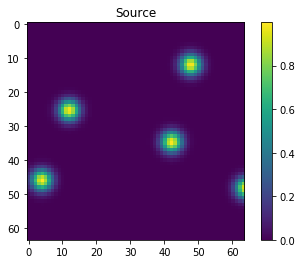

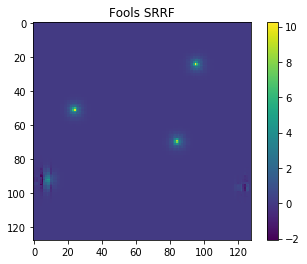

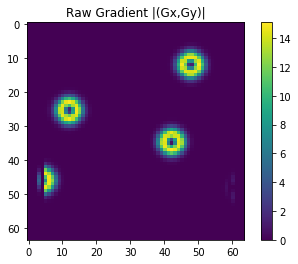

In [276]:
(i, x, y) = calc_radiality(source, get_ring_samples(1,12), scale = 2)

plt.figure()
plt.imshow(source)
plt.title('Source')
plt.colorbar()

plt.figure()
plt.imshow(-1*i)
plt.title('Fools SRRF')
plt.colorbar()

plt.figure()
plt.title('Raw Gradient |(Gx,Gy)|')
plt.imshow(x**2+y**2)
plt.colorbar()

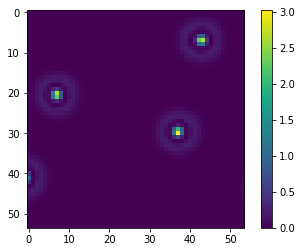

In [288]:
m = np.sqrt(x**2+y**2)
mm = np.max(m)
plt.imshow( (source*(mm-m))[5:-5,5:-5] )
plt.colorbar()